# Q2 and Loss visualization (AMN and ecAMN)

COMPREHENSIVE ANALYSIS: ecAMN vs AMN - Performance Analysis (GMM + Joint + Prob)

1. LOADING DATA...
--------------------------------------------------
Loading AMN data...
Loaded 1000 rows for AMN
Loaded 200 Q2 values for AMN

Loading ecAMN data...
Loaded 1000 rows for ecAMN
Loaded 200 Q2 values for ecAMN
Final combined dataset: (400, 5)

2. DESCRIPTIVE STATISTICS
--------------------------------------------------
   Model  Count  Mean Q²  Median Q²  Std Q²  Min Q²  Max Q²  Mean Val Loss  \
0    AMN    200  -1.3771    -1.0245  1.6111 -6.1684  0.8025         0.0043   
1  ecAMN    200   0.4640     0.6872  0.6122 -2.5748  0.8150         0.0010   

   Median Val Loss  Std Val Loss  Q² > 0.7 %  Q² ≤ 0 %  
0           0.0036        0.0029        18.5      78.5  
1           0.0006        0.0011        43.0      13.0  

3. NORMALITY TESTING AND STATISTICAL SIGNIFICANCE TESTING
--------------------------------------------------

AMN - Q2 value Normality Tests:
  Shapiro-Wilk: W = 0.9238, p = 0

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


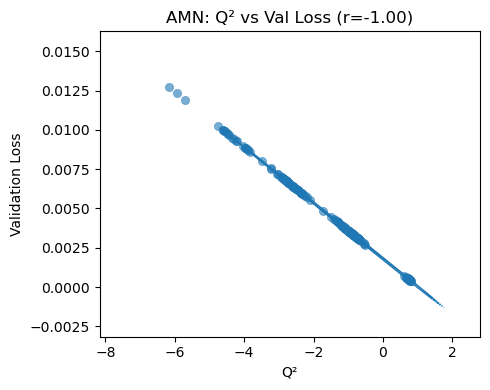

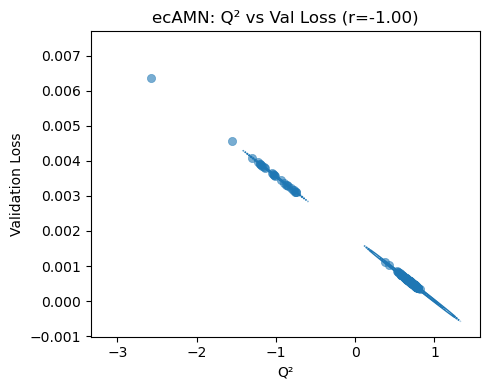

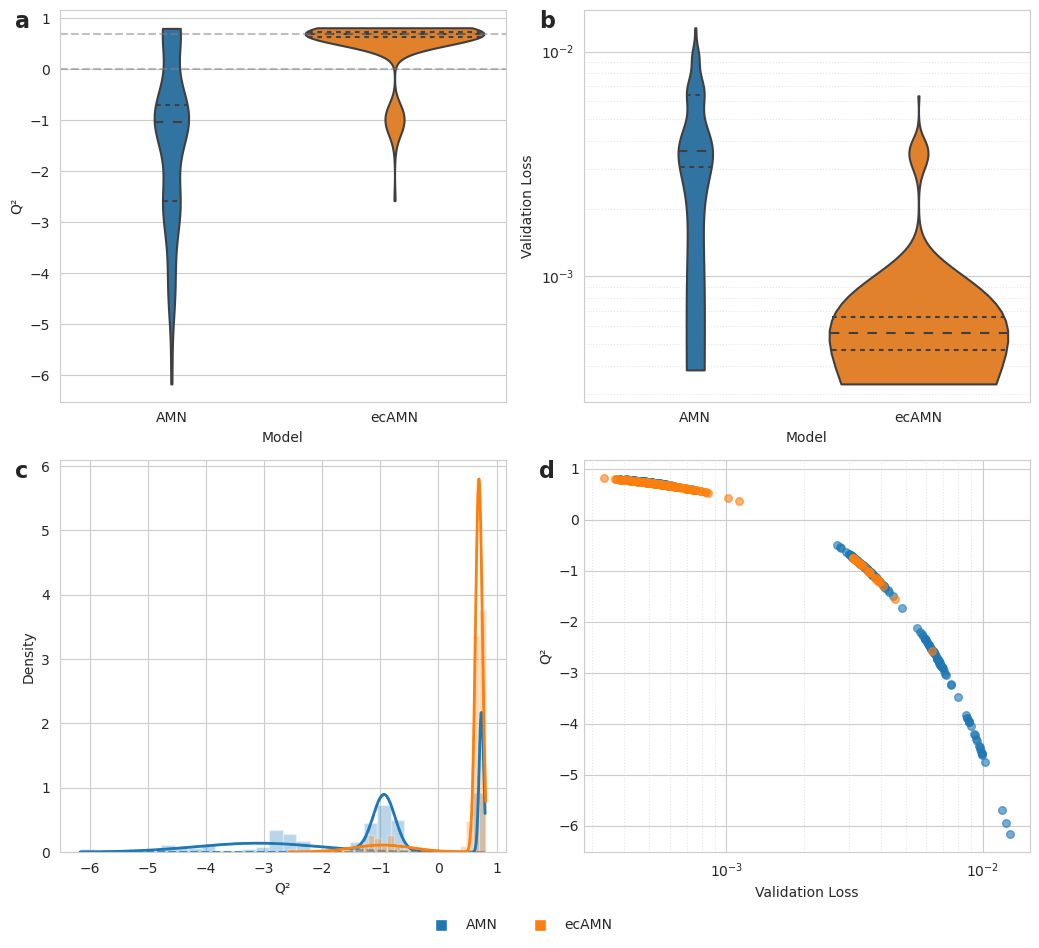


Analysis complete. Figures saved: fig_q2_vs_loss_joint.png, AMN_vs_ecAMN.png, AMN_vs_ecAMN.svg


In [ ]:
# COMPREHENSIVE ANALYSIS: ecAMN vs AMN - Performance Analysis (GMM + Joint + Prob)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import levene, ks_2samp, shapiro, normaltest
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import os
import glob
from sklearn.model_selection import StratifiedKFold
import matplotlib.ticker as ticker
from matplotlib.ticker import LogLocator
import warnings
warnings.filterwarnings("ignore")

print("="*80)
print("COMPREHENSIVE ANALYSIS: ecAMN vs AMN - Performance Analysis (GMM + Joint + Prob)")
print("="*80)

# ============================================================================
# 1. DATA LOADING FUNCTIONS
# ============================================================================

def load_loss_data(csv_folder, model_name):
    """Load loss data from CSV files"""
    csv_files = [f for f in glob.glob(os.path.join(csv_folder, "*.csv")) if "LOSS" in os.path.basename(f)]
    
    all_data = []
    
    for csv_file in csv_files:
        try:
            seed_id = os.path.basename(csv_file).split('_')[-2][4:]
            df = pd.read_csv(csv_file)
            df['Seed'] = int(seed_id)
            df['Model'] = model_name
            all_data.append(df)
        except Exception as e:
            print(f"Error processing {csv_file}: {e}")
            continue
    
    if not all_data:
        print(f"No data loaded for {model_name}")
        return None
        
    df_combined = pd.concat(all_data, ignore_index=True)
    df_combined = df_combined.rename(columns={'Run': 'Fold', 'Final_Val_Loss': 'Val_Loss'})
    
    print(f"Loaded {len(df_combined)} rows for {model_name}")
    return df_combined

def get_q2_df(folder_path, model_name):
    """Load Q2 data from CSV files"""
    import re
    data = []

    for filename in os.listdir(folder_path):
        if 'Q2' in filename and filename.endswith('.csv'):
            match = re.search(r'seed(\d+)', filename)
            if match:
                seed = int(match.group(1))
                file_path = os.path.join(folder_path, filename)
                with open(file_path, 'r') as file:
                    content = file.read().strip()
                    try:
                        content = float(content)
                    except ValueError:
                        continue

                data.append({'Seed': seed, 'Q2 value': content, 'Model': model_name})

    df = pd.DataFrame(data)
    df.sort_values(by='Seed', inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    print(f"Loaded {len(df)} Q2 values for {model_name}")
    return df

# ============================================================================
# 2. LOAD AND COMBINE DATA
# ============================================================================

print("\n1. LOADING DATA...")
print("-" * 50)

# Load data for both models
print("Loading AMN data...")
loss_amn = load_loss_data("Result/EXP_200_seed", "AMN")  # Change path for AMN
q2_amn = get_q2_df("Result/EXP_200_seed", "AMN")  # Change path for AMN

print("\nLoading ecAMN data...")
loss_ecamn = load_loss_data("Result/ec_EXP_200_seed_2", "ecAMN")  # Change path for ecAMN
q2_ecamn = get_q2_df("Result/ec_EXP_200_seed_2", "ecAMN")  # Change path for ecAMN

# Check data loading
if loss_amn is None or loss_ecamn is None or q2_amn is None or q2_ecamn is None:
    raise ValueError("Failed to load data for one or both models")

# Combine data
loss_combined = pd.concat([loss_amn, loss_ecamn], ignore_index=True)
q2_combined = pd.concat([q2_amn, q2_ecamn], ignore_index=True)

# Aggregate loss data by seed
loss_by_seed = loss_combined.groupby(['Seed', 'Model']).agg({
    'Final_Train_Loss': 'mean',
    'Val_Loss': 'mean'
}).reset_index()

# Merge loss and Q2 data
combined_analysis = pd.merge(loss_by_seed, q2_combined, on=['Seed', 'Model'], how='inner')
print(f"Final combined dataset: {combined_analysis.shape}")

# ============================================================================
# 3. DESCRIPTIVE STATISTICS TABLE
# ============================================================================

print("\n2. DESCRIPTIVE STATISTICS")
print("-" * 50)

def detailed_descriptive_stats(df, model_name):
    """Generate comprehensive descriptive statistics"""
    data_q2 = df[df['Model'] == model_name]['Q2 value']
    data_loss = df[df['Model'] == model_name]['Val_Loss']
    
    stats_dict = {
        'Model': model_name,
        'Count': len(data_q2),
        'Mean Q²': np.mean(data_q2),
        'Median Q²': np.median(data_q2),
        'Std Q²': np.std(data_q2, ddof=1),
        'Min Q²': np.min(data_q2),
        'Max Q²': np.max(data_q2),
        'Mean Val Loss': np.mean(data_loss),
        'Median Val Loss': np.median(data_loss),
        'Std Val Loss': np.std(data_loss, ddof=1),
        'Q² > 0.7 %': (data_q2 > 0.7).mean() * 100,
        'Q² ≤ 0 %': (data_q2 <= 0).mean() * 100
    }
    
    return stats_dict

# Generate statistics
stats_amn = detailed_descriptive_stats(combined_analysis, 'AMN')
stats_ecamn = detailed_descriptive_stats(combined_analysis, 'ecAMN')

# Create comparison table
stats_table = pd.DataFrame([stats_amn, stats_ecamn])
print(stats_table.round(4))

# ============================================================================
# 4. NORMALITY TESTING AND STATISTICAL TEST SELECTION
# ============================================================================

print("\n3. NORMALITY TESTING AND STATISTICAL SIGNIFICANCE TESTING")
print("-" * 50)

# Extract data
data_AMN = combined_analysis[combined_analysis['Model'] == 'AMN']
data_ecAMN = combined_analysis[combined_analysis['Model'] == 'ecAMN']

def perform_normality_tests(data, model_name, variable_name):
    """Perform multiple normality tests and return results"""
    values = data[variable_name].values
    
    # Shapiro-Wilk test (good for small to medium samples)
    shapiro_stat, shapiro_p = shapiro(values)
    
    # D'Agostino's K^2 test (good for all sample sizes)
    dagostino_stat, dagostino_p = normaltest(values)
    
    # Kolmogorov-Smirnov test against normal distribution
    ks_stat, ks_p = ks_2samp(values, np.random.normal(np.mean(values), np.std(values), 1000))
    
    print(f"\n{model_name} - {variable_name} Normality Tests:")
    print(f"  Shapiro-Wilk: W = {shapiro_stat:.4f}, p = {shapiro_p:.4f} ({'Normal' if shapiro_p > 0.05 else 'Non-normal'})")
    print(f"  D'Agostino: K² = {dagostino_stat:.4f}, p = {dagostino_p:.4f} ({'Normal' if dagostino_p > 0.05 else 'Non-normal'})")
    
    # Determine if data is normal based on tests
    is_normal = shapiro_p > 0.05 and dagostino_p > 0.05
    
    return is_normal, shapiro_p, dagostino_p

# Perform normality tests for both variables and both models
amn_q2_normal, amn_q2_shapiro_p, amn_q2_dago_p = perform_normality_tests(data_AMN, 'AMN', 'Q2 value')
ecamn_q2_normal, ecamn_q2_shapiro_p, ecamn_q2_dago_p = perform_normality_tests(data_ecAMN, 'ecAMN', 'Q2 value')

amn_loss_normal, amn_loss_shapiro_p, amn_loss_dago_p = perform_normality_tests(data_AMN, 'AMN', 'Val_Loss')
ecamn_loss_normal, ecamn_loss_shapiro_p, ecamn_loss_dago_p = perform_normality_tests(data_ecAMN, 'ecAMN', 'Val_Loss')

# Determine appropriate statistical test based on normality
def select_and_perform_test(data1, data2, var_name, data1_normal, data2_normal):
    """Select appropriate test based on normality and perform it"""
    
    # If both distributions are normal, use t-test
    if data1_normal and data2_normal:
        print(f"\n{var_name}: Both distributions normal -> Using T-test")
        stat, p_val = stats.ttest_ind(data1, data2, equal_var=False)
        test_used = "T-test"
    else:
        # If either distribution is non-normal, use Mann-Whitney U test
        print(f"\n{var_name}: At least one distribution non-normal -> Using Mann-Whitney U test")
        stat, p_val = stats.mannwhitneyu(data1, data2, alternative='two-sided')
        test_used = "Mann-Whitney U"
    
    return stat, p_val, test_used

# Perform appropriate statistical tests
print("\n" + "="*60)
print("STATISTICAL SIGNIFICANCE TESTING RESULTS")
print("="*60)

# Q2 Performance
q2_stat, q2_p_val, q2_test_used = select_and_perform_test(
    data_ecAMN['Q2 value'], 
    data_AMN['Q2 value'],
    "Q² Performance",
    ecamn_q2_normal,
    amn_q2_normal
)

# Validation Loss  
loss_stat, loss_p_val, loss_test_used = select_and_perform_test(
    data_ecAMN['Val_Loss'], 
    data_AMN['Val_Loss'],
    "Validation Loss",
    ecamn_loss_normal,
    amn_loss_normal
)

print(f"\nQ² Performance:")
print(f"  {q2_test_used}: statistic = {q2_stat:.4f}, p = {q2_p_val} ({'SIGNIFICANT' if q2_p_val < 0.05 else 'not significant'})")

print(f"\nValidation Loss:")
print(f"  {loss_test_used}: statistic = {loss_stat:.4f}, p = {loss_p_val} ({'SIGNIFICANT' if loss_p_val < 0.05 else 'not significant'})")

# Effect size calculation
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1)**2 + (ny-1)*np.std(y, ddof=1)**2) / dof)

def cliffs_delta(x, y):
    """Calculate Cliff's delta effect size for non-parametric data"""
    n_x, n_y = len(x), len(y)
    comparisons = np.sum([np.sum(xi > y) for xi in x]) - np.sum([np.sum(xi < y) for xi in x])
    return comparisons / (n_x * n_y)

# Calculate appropriate effect sizes
if q2_test_used == "T-test":
    effect_size_q2 = cohens_d(data_ecAMN['Q2 value'], data_AMN['Q2 value'])
    effect_size_label_q2 = f"Cohen's d = {effect_size_q2:.3f}"
    size_interpretation_q2 = 'LARGE' if abs(effect_size_q2) > 0.8 else 'medium' if abs(effect_size_q2) > 0.5 else 'small'
else:
    effect_size_q2 = cliffs_delta(data_ecAMN['Q2 value'], data_AMN['Q2 value'])
    effect_size_label_q2 = f"Cliff's delta = {effect_size_q2:.3f}"
    size_interpretation_q2 = 'LARGE' if abs(effect_size_q2) > 0.474 else 'medium' if abs(effect_size_q2) > 0.33 else 'small'

if loss_test_used == "T-test":
    effect_size_loss = cohens_d(data_AMN['Val_Loss'], data_ecAMN['Val_Loss'])  # Note: reversed for loss
    effect_size_label_loss = f"Cohen's d = {effect_size_loss:.3f}"
    size_interpretation_loss = 'LARGE' if abs(effect_size_loss) > 0.8 else 'medium' if abs(effect_size_loss) > 0.5 else 'small'
else:
    effect_size_loss = cliffs_delta(data_AMN['Val_Loss'], data_ecAMN['Val_Loss'])
    effect_size_label_loss = f"Cliff's delta = {effect_size_loss:.3f}"
    size_interpretation_loss = 'LARGE' if abs(effect_size_loss) > 0.474 else 'medium' if abs(effect_size_loss) > 0.33 else 'small'

print(f"\nEffect Sizes:")
print(f"  Q²: {effect_size_label_q2} ({size_interpretation_q2})")
print(f"  Loss: {effect_size_label_loss} ({size_interpretation_loss})")

# ============================================================================
# 5. DISTRIBUTION ANALYSIS
# ============================================================================

print("\n4. DISTRIBUTION ANALYSIS (GMM + Joint Q²-Loss + Probabilities)")
print("-" * 50)

def gmm_bimodality_test(values, max_components=3, random_state=42):
    """Fit GMMs with 1..max_components; return best model by BIC and stats."""
    values = np.asarray(values).reshape(-1, 1)
    bics = []
    gmms = []
    for k in range(1, max_components+1):
        gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=random_state, n_init=5)
        gmm.fit(values)
        bics.append(gmm.bic(values))
        gmms.append(gmm)
    best_idx = int(np.argmin(bics))
    best_gmm = gmms[best_idx]
    bic_vals = bics
    return best_gmm, best_idx+1, bic_vals

def summarize_gmm(gmm, values):
    """Return component means, variances, weights, and assign probabilities."""
    values = np.asarray(values).reshape(-1,1)
    probs = gmm.predict_proba(values)  # n_samples x n_components
    comp_means = gmm.means_.flatten()
    comp_vars = np.array([np.diag(cov)[0] for cov in gmm.covariances_])
    weights = gmm.weights_.flatten()
    # Order components by mean descending
    order = np.argsort(comp_means)[::-1]
    summary = []
    for i in order:
        summary.append({
            'comp': int(i),
            'mean': float(comp_means[i]),
            'std': float(np.sqrt(comp_vars[i])),
            'weight': float(weights[i])
        })
    return summary, probs

def analyze_model_gmm(data, model_name, variable_name='Q2 value'):
    values = data[variable_name].values
    gmm, n_comp, bic_vals = gmm_bimodality_test(values, max_components=3)
    summary, probs = summarize_gmm(gmm, values)
    print(f"\n{model_name} - {variable_name}: best GMM components = {n_comp} (BICs: {np.round(bic_vals,2)})")
    for c in summary:
        print(f"  Component mean={c['mean']:.4f}, std={c['std']:.4f}, weight={c['weight']:.3f}")
    return gmm, summary, probs

# Run GMM for Q2 and Val_Loss for both models
q2_amn_gmm, q2_amn_summary, q2_amn_probs = analyze_model_gmm(data_AMN, 'AMN', 'Q2 value')
q2_ecamn_gmm, q2_ecamn_summary, q2_ecamn_probs = analyze_model_gmm(data_ecAMN, 'ecAMN', 'Q2 value')

loss_amn_gmm, loss_amn_summary, loss_amn_probs = analyze_model_gmm(data_AMN, 'AMN', 'Val_Loss')
loss_ecamn_gmm, loss_ecamn_summary, loss_ecamn_probs = analyze_model_gmm(data_ecAMN, 'ecAMN', 'Val_Loss')

# ============================================================================
# 6. Q² - Loss joint distribution analysis
# ============================================================================

def joint_q2_loss_analysis(df, model_name, ax=None, show_plot=True):
    x = df['Q2 value'].values
    y = df['Val_Loss'].values
    pearson_r, pearson_p = stats.pearsonr(x, y)
    spearman_r, spearman_p = stats.spearmanr(x, y)
    kendall_r, kendall_p = stats.kendalltau(x, y)
    print(f"\n{model_name} Q² vs Val_Loss correlations:")
    print(f"  Pearson r = {pearson_r:.3f} (p = {pearson_p:.2e})")
    print(f"  Spearman rho = {spearman_r:.3f} (p = {spearman_p:.2e})")
    print(f"  Kendall tau = {kendall_r:.3f} (p = {kendall_p:.2e})")
    
    if show_plot:
        if ax is None:
            fig, ax = plt.subplots(1,1, figsize=(5,4))
        # scatter with contour
        sns.scatterplot(x=x, y=y, ax=ax, s=35, alpha=0.6, edgecolor=None)
        try:
            sns.kdeplot(x=x, y=y, ax=ax, levels=6, linewidths=1, fill=False)
        except Exception:
            pass
        ax.set_xlabel('Q²')
        ax.set_ylabel('Validation Loss')
        ax.set_title(f"{model_name}: Q² vs Val Loss (r={pearson_r:.2f})")
        plt.tight_layout()
    return pearson_r, spearman_r, kendall_r

print("\nJoint Q²-Loss analysis (plots will be shown if running interactively):")
joint_q2_loss_analysis(data_AMN, 'AMN')
joint_q2_loss_analysis(data_ecAMN, 'ecAMN')

# Save joint plot combined for figure (both models)
fig, axs = plt.subplots(1,2,figsize=(10,4))
joint_q2_loss_analysis(data_AMN, 'AMN', ax=axs[0], show_plot=True)
joint_q2_loss_analysis(data_ecAMN, 'ecAMN', ax=axs[1], show_plot=True)
plt.savefig("fig_q2_vs_loss_joint.png", dpi=300)
plt.close(fig)

# ============================================================================
# 7. PROBABILITY-BASED METRICS
# ============================================================================

def empirical_pairwise_prob(x, y):
    """Empirical P(X > Y) computed over all pairs (efficient vectorized)."""
    x = np.asarray(x)
    y = np.asarray(y)
    # compute proportion of pairs where x_i > y_j
    # vectorized approach:
    # for memory safety, use broadcasting in chunks if arrays are large; here n~200 so OK
    comp = (x.reshape(-1,1) > y.reshape(1,-1))
    prob = comp.mean()
    return prob

def bootstrap_prob_mean_diff(x, y, n_boot=10000, random_state=42):
    rng = np.random.RandomState(random_state)
    x = np.asarray(x)
    y = np.asarray(y)
    n_x = len(x)
    n_y = len(y)
    diffs = []
    for _ in range(n_boot):
        sx = rng.choice(x, size=n_x, replace=True)
        sy = rng.choice(y, size=n_y, replace=True)
        diffs.append(sx.mean() - sy.mean())
    diffs = np.array(diffs)
    prob = (diffs > 0).mean()
    ci_lower = np.percentile(diffs, 2.5)
    ci_upper = np.percentile(diffs, 97.5)
    return prob, (ci_lower, ci_upper), diffs

# Empirical probability that a random ecAMN Q2 > random AMN Q2
prob_ec_greater_amn = empirical_pairwise_prob(data_ecAMN['Q2 value'].values, data_AMN['Q2 value'].values)
print(f"\nEmpirical P(random ecAMN Q² > random AMN Q²) = {prob_ec_greater_amn:.3f}")

# Bootstrap probability that mean(ecAMN) > mean(AMN)
boot_prob, boot_ci, diffs = bootstrap_prob_mean_diff(data_ecAMN['Q2 value'].values, data_AMN['Q2 value'].values, n_boot=5000)
print(f"Bootstrap P(mean(ecAMN) > mean(AMN)) = {boot_prob:.3f}, 95% CI for mean diff = [{boot_ci[0]:.3f}, {boot_ci[1]:.3f}]")

# Also report the reverse for loss (we expect smaller loss in ecAMN)
prob_amn_greater_loss = empirical_pairwise_prob(data_AMN['Val_Loss'].values, data_ecAMN['Val_Loss'].values)
boot_prob_loss, boot_ci_loss, diffs_loss = bootstrap_prob_mean_diff(data_AMN['Val_Loss'].values, data_ecAMN['Val_Loss'].values, n_boot=5000)
print(f"\nEmpirical P(random AMN loss > random ecAMN loss) = {prob_amn_greater_loss:.3f}")
print(f"Bootstrap P(mean(AMN loss) > mean(ecAMN loss)) = {boot_prob_loss:.3f}, 95% CI for mean diff = [{boot_ci_loss[0]:.6f}, {boot_ci_loss[1]:.6f}]")

# ============================================================================
# 8. CLUSTER ANALYSIS
# ============================================================================

def analyze_multivariate_clusters(data, model_name, features=['Q2 value','Val_Loss'], n_clusters=2):
    X = data[features].values
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
    labels = kmeans.fit_predict(X)
    sil = silhouette_score(X, labels)
    print(f"\n{model_name} multivariate clustering ({'+'.join(features)}):")
    print(f"  Silhouette = {sil:.3f}")
    for i in range(n_clusters):
        subset = data.iloc[np.where(labels==i)]
        print(f"  Cluster {i}: n={len(subset)}, meanQ2={subset['Q2 value'].mean():.3f}, meanLoss={subset['Val_Loss'].mean():.5f}")
    return labels, kmeans

print("\nMultivariate clustering (Q² + Val_Loss):")
labels_amn, k_amn = analyze_multivariate_clusters(data_AMN, 'AMN', n_clusters=2)
labels_ecamn, k_ecamn = analyze_multivariate_clusters(data_ecAMN, 'ecAMN', n_clusters=2)

# ============================================================================
# 9. Distribution shape tests
# ============================================================================

levene_q2 = levene(data_AMN['Q2 value'], data_ecAMN['Q2 value'])
levene_loss = levene(data_AMN['Val_Loss'], data_ecAMN['Val_Loss'])
ks_q2 = ks_2samp(data_AMN['Q2 value'], data_ecAMN['Q2 value'])
ks_loss = ks_2samp(data_AMN['Val_Loss'], data_ecAMN['Val_Loss'])

print(f"\nDistribution Tests:")
print(f"  Q² variances: p = {levene_q2.pvalue:.2e} ({'DIFFERENT' if levene_q2.pvalue < 0.05 else 'similar'})")
print(f"  Loss variances: p = {levene_loss.pvalue:.2e} ({'DIFFERENT' if levene_loss.pvalue < 0.05 else 'similar'})")
print(f"  Q² distributions: p = {ks_q2.pvalue:.2e} ({'DIFFERENT' if ks_q2.pvalue < 0.05 else 'similar'})")
print(f"  Loss distributions: p = {ks_loss.pvalue:.2e} ({'DIFFERENT' if ks_loss.pvalue < 0.05 else 'similar'})")

# ============================================================================
# 10. Four-panel performance comparison
# ============================================================================

print("\n5. CREATING FOUR-PANEL VISUALIZATION...")

# Set clean style
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'Arial'

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(10.5, 10))
colors = {"AMN": "#1F77B4", "ecAMN": "#FF7F0E"}

# ------------------------------------------------------------
# Helper: Fit GMM and plot histogram + mixture curve (FIXED for ecAMN)
# ------------------------------------------------------------
def plot_gmm_density_fixed(ax, data, color, model_name, title=""):
    # Histogram
    ax.hist(data, bins=30, density=True, alpha=0.3, color=color)

    # Fit GMM - force 2 components for ecAMN, use BIC for AMN
    if model_name == 'ecAMN':
        n_components = 2
        gmm = GaussianMixture(n_components=n_components, random_state=0)
        gmm.fit(data.reshape(-1, 1))
    else:
        # Use BIC selection for AMN
        bics = []
        gmms = []
        for k in range(1, 4):
            gmm = GaussianMixture(n_components=k, random_state=0)
            gmm.fit(data.reshape(-1, 1))
            gmms.append(gmm)
            bics.append(gmm.bic(data.reshape(-1, 1)))
        best_k = np.argmin(bics)
        gmm = gmms[best_k]
        n_components = best_k + 1

    # x-range
    x = np.linspace(min(data), max(data), 500).reshape(-1, 1)

    # Total density
    total_density = np.exp(gmm.score_samples(x))
    ax.plot(x, total_density, color=color, lw=2, label=f"GMM (k={n_components})")

    # Individual components
    means = gmm.means_.flatten()
    stds = np.sqrt(gmm.covariances_).flatten()
    weights = gmm.weights_

    for m, s, w in zip(means, stds, weights):
        component = w * (1/np.sqrt(2*np.pi*s**2)) * np.exp(-0.5*((x - m)/s)**2)
        ax.plot(x, component, ls="--", color=color, alpha=0.6)

    ax.set_title(title, fontsize=12)
    ax.set_ylabel("Density")

label_coordinate_x = -0.1

# ------------------------------------------------------------
# Panel A: Q² distribution (Violin)
# ------------------------------------------------------------
ax = axes[0, 0]
sns.violinplot(data=combined_analysis, x='Model', y='Q2 value',
               ax=ax, palette=colors, inner='quartile', cut=0)
ax.text(label_coordinate_x, 1.0, "a", transform=ax.transAxes, fontsize=16,
        fontweight="bold", va='top')
ax.set_ylabel("Q²")
ax.axhline(0.7, linestyle='--', color='gray', alpha=0.5)
ax.axhline(0, linestyle='--', color='gray', alpha=0.5)

# ------------------------------------------------------------
# Panel B: Validation Loss (Violin)
# ------------------------------------------------------------
ax = axes[0, 1]
sns.violinplot(data=combined_analysis, x='Model', y='Val_Loss',
               ax=ax, palette=colors, inner='quartile', cut=0)
ax.text(label_coordinate_x, 1.0, "b", transform=ax.transAxes, fontsize=16,
        fontweight="bold", va='top')
ax.set_ylabel("Validation Loss")
ax.set_yscale("log")
ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(1, 10) * 0.1, numticks=10))
ax.grid(which='minor', linestyle=':', alpha=0.5)

# ------------------------------------------------------------
# Panel C: GMM-based Q² density (FIXED - forced 2 components for ecAMN)
# ------------------------------------------------------------
ax = axes[1, 0]
for model, color in colors.items():
    data = combined_analysis[combined_analysis['Model'] == model]['Q2 value'].values
    plot_gmm_density_fixed(ax, data, color, model)

ax.text(label_coordinate_x, 1.0, "c", transform=ax.transAxes, fontsize=16,
        fontweight="bold", va='top')
ax.set_xlabel("Q²")

# ------------------------------------------------------------
# Panel D: Joint Q²–Loss scatter (no correlation text)
# ------------------------------------------------------------
ax = axes[1, 1]
for model, color in colors.items():
    subset = combined_analysis[combined_analysis['Model'] == model]
    ax.scatter(subset['Val_Loss'], subset['Q2 value'],
               alpha=0.6, s=30, color=color, label=model)
ax.text(label_coordinate_x, 1.0, "d", transform=ax.transAxes, fontsize=16,
        fontweight="bold", va='top')
ax.set_xscale("log")
ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(1, 10) * 0.1, numticks=10))
ax.grid(which='minor', linestyle=':', alpha=0.5)
ax.tick_params(axis='x', which='minor', length=4, width=1)  # make them visible
ax.tick_params(axis='y', which='both', direction='in')
ax.set_xlabel("Validation Loss")
ax.set_ylabel("Q²")

# ------------------------------------------------------------
# Universal legend
# ------------------------------------------------------------
legend_elements = [
    plt.Line2D([0], [0], marker='s', color='w',
               markerfacecolor=colors['AMN'], markersize=8, label='AMN'),
    plt.Line2D([0], [0], marker='s', color='w',
               markerfacecolor=colors['ecAMN'], markersize=8, label='ecAMN')
]

fig.legend(handles=legend_elements, loc='lower center',
           bbox_to_anchor=(0.5, 0.05), ncol=2, frameon=False)

plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.savefig("AMN_vs_ecAMN.png", dpi=1000, bbox_inches="tight")
plt.savefig("AMN_vs_ecAMN.svg")
plt.show()

print("\nAnalysis complete. Figures saved: fig_q2_vs_loss_joint.png, AMN_vs_ecAMN.png, AMN_vs_ecAMN.svg")